In [145]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
pd.options.mode.copy_on_write = True

In [101]:
basin_mapping_SVAR = {
    'BASIN_NR_1': 'Bottenviken',
    'BASIN_NR_2': 'Norra Kvarken',
    'BASIN_NR_3': 'Bottenhavet',
    'BASIN_NR_4': 'Ålands hav',
    'BASIN_NR_5': 'Skärgårdshavet',
    'BASIN_NR_6': 'Finska viken',
    'BASIN_NR_7': 'Norra Gotlandshavet',
    'BASIN_NR_8': 'Västra Gotlandshavet',
    'BASIN_NR_9': 'Östra Gotlandshavet',
    'BASIN_NR_10': 'Rigabukten',
    'BASIN_NR_11': 'Gdanskbukten',
    'BASIN_NR_12': 'Bornholmshavet & Hanöbukten',
    'BASIN_NR_13': 'Arkonahavet & Södra Öresund',
    'BASIN_NR_14': 'Bälthavet',
    'BASIN_NR_15': 'Öresund',
    'BASIN_NR_16': 'Kattegatt',
    'BASIN_NR_17': 'Skagerrak',
}

In [107]:
basin_mapping_SVAR = {
    1: 'Bottenviken',
    2: 'Norra Kvarken',
    3: 'Bottenhavet',
    4: 'Ålands hav',
    5: 'Skärgårdshavet',
    6: 'Finska viken',
    7: 'Norra Gotlandshavet',
    8: 'Västra Gotlandshavet',
    9: 'Östra Gotlandshavet',
    10: 'Rigabukten',
    11: 'Gdanskbukten',
    12: 'Bornholmshavet & Hanöbukten',
    13: 'Arkonahavet & Södra Öresund',
    14: 'Bälthavet',
    15: 'Öresund',
    16: 'Kattegatt',
    17: 'Skagerrak',
}

In [4]:
def generate_filepaths(directory, pattern='', not_pattern='DUMMY_PATTERN',
                       pattern_list=[], endswith='',
                       only_from_dir=True):
    for path, subdir, fids in os.walk(directory):
        if only_from_dir:
            if path != directory:
                continue
        # Generator function (uses yield) https://docs.python.org/3/glossary.html#term-generator
        for f in fids:
            if pattern in f and not_pattern not in f and f.endswith(endswith):
                if any(pattern_list):
                    for pat in pattern_list:
                        if pat in f:
                            yield os.path.abspath(os.path.join(path, f))
                else:
                    yield os.path.abspath(os.path.join(path, f))

Set up dataframe containing geom definitions for each selected basin and append the total area of the geom in a new area column

In [5]:
areas = gpd.read_file(
        r'c:\Arbetsmapp\Shapefiler\Sub-basins_Baltic_Sea\Havsomr_SVAR_2016_3b.shp'
)
areas = areas.to_crs(epsg=3006)
areas_geometries = areas[['BASIN_NR', 'geometry']]
areas = areas_geometries.dissolve(by='BASIN_NR', as_index=False)
selected_basins = (3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17)
boolean_filter = areas['BASIN_NR'].isin(selected_basins)
areas = areas.loc[boolean_filter, :].reset_index(drop=True)
areas['area'] = areas['geometry'].apply(lambda geom: int(geom.area))

<Axes: >

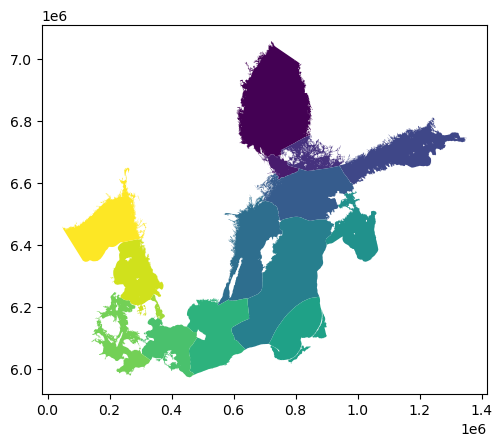

In [6]:
areas.plot('BASIN_NR')

In [127]:
# data_dir = r'C:\Arbetsmapp\BAWS\shp_data'
data_dir = r'C:\Arbetsmapp\BAWS\test_data'

In [141]:
files = generate_filepaths(data_dir, endswith='.shp')
# file_ts = pd.Timestamp(os.path.basename(main_file).split('.')[0].split('_')[-1])

In [122]:
shp_file = data_dir + r'\cyano_daymap_20220815.shp'
gdf = gpd.read_file(shp_file)
sindex = gdf.sindex

In [135]:
file_ts = pd.Timestamp(os.path.basename(shp_file).split('.')[0].split('_')[-1])
print(file_ts)

2022-08-15 00:00:00


In [12]:
blooms = gdf[gdf['class'].isin([2, 3])]

In [15]:
basin_bloom_area = gpd.overlay(blooms, selected_basin, how='intersection')

In [18]:
basin_bloom_area

,class,BASIN_NR,area,geometry
0,2,12,33668211507,"POLYGON ((580261.000 6219123.000, 579261.000 6..."
1,2,12,33668211507,"POLYGON ((575261.000 6218123.000, 574261.000 6..."
2,3,12,33668211507,"POLYGON ((573261.000 6218123.000, 573261.000 6..."
3,3,12,33668211507,"POLYGON ((575261.000 6218123.000, 575261.000 6..."
4,2,12,33668211507,"POLYGON ((517261.000 6217123.000, 517261.000 6..."
...,...,...,...,...
1263,2,12,33668211507,"POLYGON ((463261.000 6034123.000, 463261.000 6..."
1264,2,12,33668211507,"POLYGON ((462261.000 6028123.000, 462261.000 6..."
1265,2,12,33668211507,"POLYGON ((460261.000 6027123.000, 460261.000 6..."
1266,2,12,33668211507,"POLYGON ((461261.000 6024123.000, 461261.000 6..."


In [118]:
basin_data = []
selected_basin = []

In [119]:
for n in selected_basins:
    basin_nr = areas['BASIN_NR'].isin([n])
    basin_bloom_overlap = gpd.overlay(blooms, areas[basin_nr], how='intersection')
    basin_data.append(basin_bloom_overlap)
    selected_basin.append(areas[basin_nr])

In [120]:
basin_map = [basin_mapping_SVAR[item] for item in selected_basins]
print(basin_map)

['Bottenhavet', 'Ålands hav', 'Skärgårdshavet', 'Finska viken', 'Norra Gotlandshavet', 'Västra Gotlandshavet', 'Östra Gotlandshavet', 'Rigabukten', 'Gdanskbukten', 'Bornholmshavet & Hanöbukten', 'Arkonahavet & Södra Öresund', 'Bälthavet', 'Öresund', 'Kattegatt', 'Skagerrak']


C:\Users\k000851\AppData\Local\Temp\ipykernel_5280\4071858494.py:10: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  basin_data.plot(ax=axs[i], color='black')
C:\Users\k000851\AppData\Local\Temp\ipykernel_5280\4071858494.py:10: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  basin_data.plot(ax=axs[i], color='black')
C:\Users\k000851\AppData\Local\Temp\ipykernel_5280\4071858494.py:10: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  basin_data.plot(ax=axs[i], color='black')


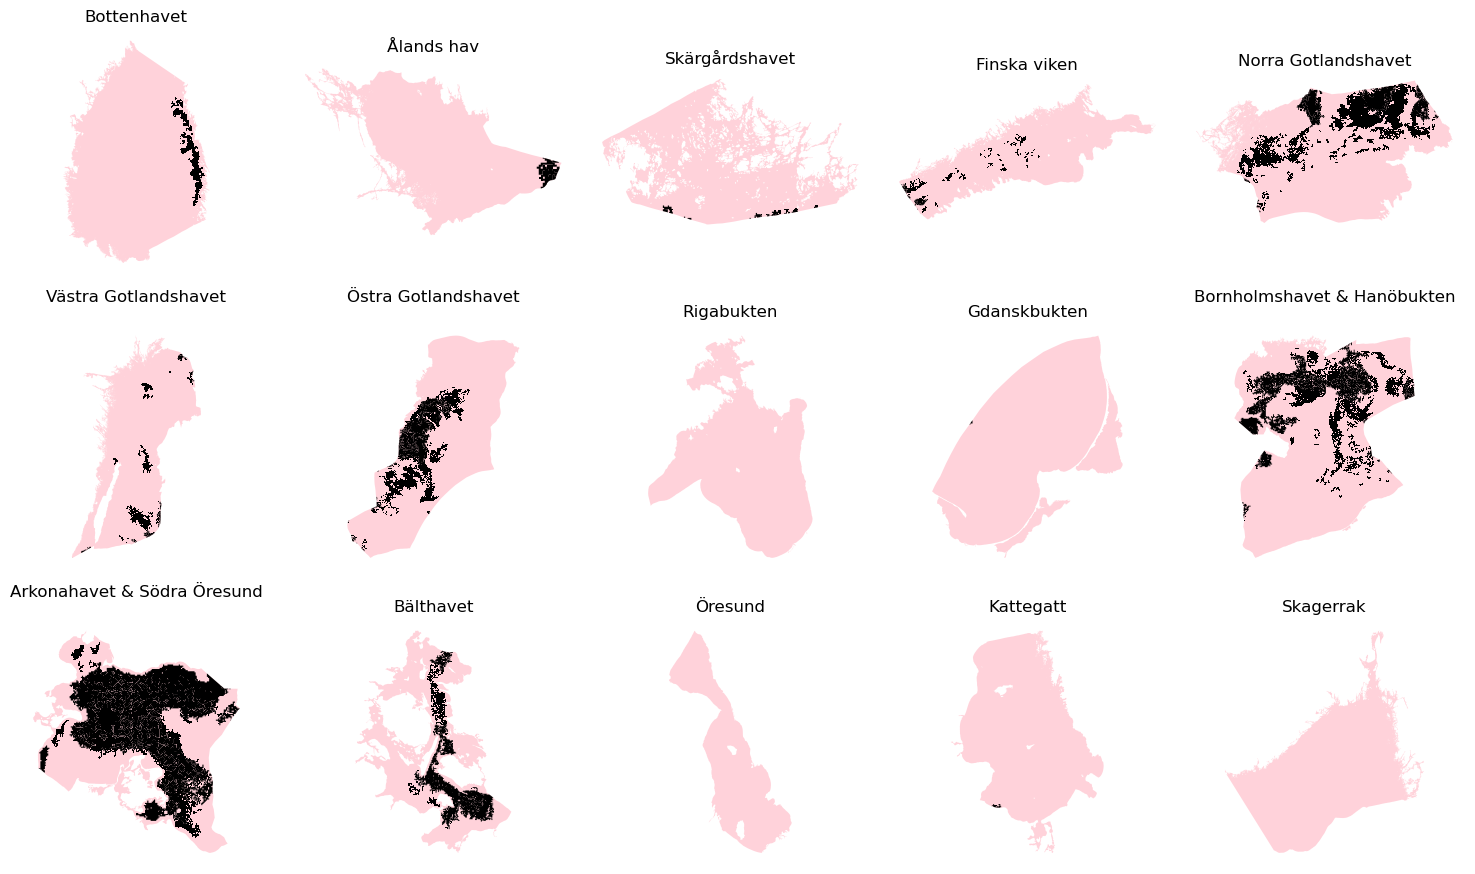

In [121]:
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.flatten()

for ax, basin_name in zip(axs.ravel(), basin_map):
    ax.axis('off')
    ax.set_title(basin_name)
for n, selected_basin in enumerate(selected_basin):
    selected_basin.plot(ax=axs[n], alpha=0.7, color='pink')
for i, basin_data in enumerate(basin_data):
    basin_data.plot(ax=axs[i], color='black')

plt.tight_layout()
plt.show()

In [42]:
for n in selected_basins:
    basin_nr = areas['BASIN_NR'].isin([n])
    basin_bloom_overlap = gp.overlay(blooms, areas[basin_nr], how='intersection')
    bloom_area_sum = basin_bloom_overlap.area.sum()
    areas.loc[basin_nr, 'bloom_area'] = bloom_area_sum
areas

,BASIN_NR,geometry,area,bloom_area
0,3,"POLYGON ((620922.743 6729219.402, 620757.133 6...",60609721586,2.039821e+09
1,4,"POLYGON ((709486.835 6669336.804, 709413.026 6...",4337600600,8.814282e+07
2,5,"POLYGON ((941642.960 6656019.222, 941484.624 6...",10883952173,1.010615e+08
3,6,"POLYGON ((984634.061 6596697.898, 984670.443 6...",30407673759,1.194335e+09
4,7,"POLYGON ((693957.780 6565996.762, 693875.447 6...",34845257524,8.088755e+09
5,8,"POLYGON ((549687.035 6208329.209, 549711.191 6...",34575748071,1.776576e+09
6,9,"POLYGON ((706381.131 6322005.715, 706379.902 6...",64599679622,1.270830e+10
7,10,"POLYGON ((899983.436 6399829.630, 899925.798 6...",18327887795,0.000000e+00
8,11,"POLYGON ((876400.422 6233011.174, 876417.638 6...",21965530085,4.298355e+06
9,12,"POLYGON ((449029.888 6137863.106, 449177.826 6...",33668211507,7.806345e+09


# Time series

In [146]:
datasets = []

for shapefile in files:
    gdf = gpd.read_file(shapefile)
    
    filename = os.path.basename(shapefile)
    file_ts = pd.Timestamp(os.path.basename(shapefile).split('.')[0].split('_')[-1])
    date = pd.to_datetime(file_ts)
    ds = xr.Dataset.from_dataframe(gdf)

    ds = ds.assign_coords(time=date)

    datasets.append(ds)

ds_all = xr.concat(datasets, dim='time')

In [ ]:
ds_all